<a href="https://colab.research.google.com/github/rimchristian/sales-prediction/blob/main/salesprediction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Goal of the Task**##
###The goal is to help the retailer understand the properties of products and outliets to predict sales###

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

In [ ]:
filename = '/content/sales_predictions.csv'
df = pd.read_csv(filename,decimal=',')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047301,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138
1,DRC01,5.92,Regular,0.019278216,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5,Low Fat,0.016760075,Meat,141.618,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27
3,FDX07,19.2,Regular,0,Fruits and Vegetables,182.095,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
# drop duplicates 
df.duplicated().sum() 
# no duplicates

0

In [ ]:
# identifying missing data 
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
df.dtypes

Item_Identifier              object
Item_Weight                  object
Item_Fat_Content             object
Item_Visibility              object
Item_Type                    object
Item_MRP                     object
Outlet_Identifier            object
Outlet_Establishment_Year     int64
Outlet_Size                  object
Outlet_Location_Type         object
Outlet_Type                  object
Item_Outlet_Sales            object
dtype: object

In [ ]:
# split
X = df.drop(columns=['Item_Outlet_Sales','Item_Identifier','Item_Weight', 'Item_Visibility','Item_Type','Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Fat_Content', 'Outlet_Identifier'])
y = df['Item_Outlet_Sales']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [ ]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [ ]:
# Instantiate an imputer and scaler 
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
#scaler
scaler = StandardScaler()
# One hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer,scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [ ]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer,ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [ ]:
# Tuples for Columnn Transformer
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (categorical_pipe,cat_selector)

# ColumnTransformer
preprocessor = make_column_transformer(num_tuple,cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb4667e6eb0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb4667e66d0>)])

In [ ]:
# combine the imputer and the scaler into a pipeline 
preprocessing_pipeline = make_pipeline(freq_imputer, scaler)
preprocessing_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('standardscaler', StandardScaler())])

In [ ]:
preprocessor.fit(X_train) # fit on the training dataset

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb4667e6eb0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb4667e66d0>)])

In [ ]:
# transforming train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
#displaying the preprocessing steps
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data.')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data.')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data.
0 missing values in testing data.


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 5274)




array([[ 1.32784893,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.32784893,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13618724,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.49368575,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0895166 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.10214509,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

##**Model 1: Building Linear Regression Model**


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# importing the linearregression library
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [ ]:
# modeling the pipeline
from sklearn.pipeline import make_pipeline
reg_pipe = make_pipeline(scaler, reg)

In [ ]:
# making the Item Fat Content column more consistent
df['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'}, inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
# changing the caterical variables to numeric values
df['Item_Fat_Content'].value_counts()
df['Item_Fat_Content'].replace({'Low Fat': 0, 'Regular':1}, inplace=True)
df['Item_Fat_Content'].value_counts()

0    5517
1    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
predictions = reg_pipe.predict(X_test)
predictions

array([1372.64605243,  672.8177138 ,  637.03871145, ..., 3225.6437947 ,
       1837.23631132, 2203.28001411])

In [ ]:
# Create model pipeline
train_pred = reg_pipe.predict(X_train)
test_pred = reg_pipe.predict(X_test)

##**Regression Metric: Mean Squared Error**##

In [ ]:
# calculating mse
train_mse = mean_squared_error(y_train,train_pred)
test_mse = mean_squared_error(y_test,test_pred)

print(f'Model Training: {train_mse}')
print(f'Model Testing: {test_mse}')

Model Training: 1997551.6054020615
Model Testing: 1873063.7979226657


##**Metric for Linear Regression Model**##
- The MSE is more useful for the linear regression model, because it penalizes larger erros. The Model test results is lower than the train dataset, which means is better. 

##**Model 2: Regression Tree Model**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = DecisionTreeRegressor(random_state=42)


In [ ]:
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
# predicting the target values
train_preds = dec_tree.predict(X_train)
test_preds = dec_tree.predict(X_test)



In [ ]:
# evauluating the model
train_score = dec_tree.score(X_train,y_train)
test_score = dec_tree.score(X_test,y_test)

print(train_score)
print(test_score)

0.9770305627951709
-0.1812493379076403


The result for the tree model shows that it is way overfitting.  I will go ahead and tune my model. 

In [ ]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
dec_tree.get_depth()

32

In [ ]:
dec_tree.get_n_leaves()

6157

In [ ]:
# List of values to try for max_depth:
depths = list(range(2, 28)) # Will input every value between 2 and 28
# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train, y_train)
    train_score = dec_tree.score(X_train, y_train)
    test_score = dec_tree.score(X_test, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score


Text(0, 0.5, 'R2')

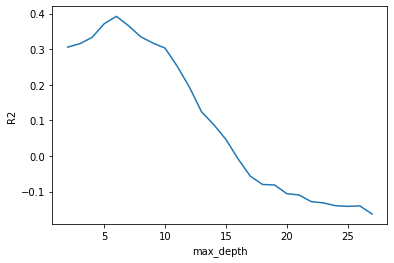

In [ ]:
import matplotlib.pyplot as plt
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2')

In [ ]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
6,0.392557,0.437989
5,0.371732,0.404251
7,0.366204,0.463358
8,0.335129,0.487111
4,0.333298,0.348056


In [ ]:
# Let's run the model with our optimized value for max_depth
dec_tree_6 = DecisionTreeRegressor(max_depth = 6, random_state = 42)
dec_tree_6.fit(X_train, y_train)
train_6_score = dec_tree_6.score(X_train, y_train)
test_6_score = dec_tree_6.score(X_test, y_test)
print(train_6_score)
print(test_6_score)


0.4379894023439658
0.39255745390098207


From the model we have built for the Tree model, the greatest value for max_depth is 6.  The training score is higher than the testing score.  

**R-Squared Regression Metric**

In [ ]:
# Calculating R2
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f'Model Training: {train_r2}')
print(f'Model Testing: {test_r2}')

Model Training: 0.32502736826006273
Model Testing: 0.3211021322282348


##Regression Metrics##
Based on the R-squared, our model can account for about 32%.  
The correlation coeffciant is low, so the model isn't really strong.  It measures the variance of the model.
For the **regression tree model**, the r^2 is better because it is in the same range than the MSE. 

##**Model Comparison**

Based on the two models, I would recommend the **regression tree model** because of the structure.  The training score is higher and it is easy to interpret. While the linear regression model is formed by arrays, it is hard to understand for non-technical audiences.  I would also recommend the tree model because of its efficiency and interpretation.